# 概要

* アタポンの1位データy予測
* GBMで試してみる
  * 前数回分のイベントの情報を説明変数にしてみる

# インポート

In [1]:
import numpy as np
import pandas as pd
import pickle
import datetime
from datetime import timedelta
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font=['IPAMincho'])

import seaborn as sns
from sklearn.metrics import r2_score

# イベントデータ読み込み

In [2]:
input_dir = './data/'

In [3]:
df = pd.read_pickle(input_dir + 'a3_output_df.pkl')
df = df[df['形式'] == 'アタポン'].set_index('日付')
df.head()

,イベント,1位,2001位,形式,属性,期間
日付,,,,,,
2015-09-25,アタシポンコツアンドロイド,427777,78330,アタポン,NaN,249.0
2015-10-19,Nation Blue,324369,67627,アタポン,NaN,198.0
2015-11-20,Orange Sapphire,350000,42944,アタポン,NaN,150.0
2015-12-18,Snow Wings,520000,50954,アタポン,NaN,222.0
2016-01-20,パステルピンクな恋,602529,43854,アタポン,NaN,174.0


findfont: Font family ['IPAMincho'] not found. Falling back to DejaVu Sans.


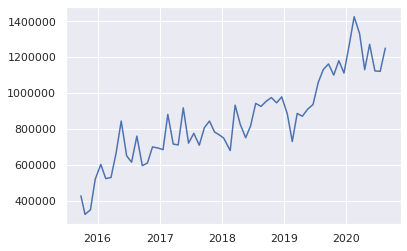

In [4]:
# プロットしてみる
fig = plt.figure()
ax = fig.add_subplot(111)
x = df.index
y = df.loc[:, '1位']
ax.plot(x, y)
plt.show()

# データ準備

In [5]:
# 必要な列のみに絞る
# 日付順に並べる
# 列名変更
df = (
    df
    .loc[:, ['イベント', '1位', '期間']]
    .sort_index()
    .rename(columns={'イベント': 'event_name', '1位': 'point', '期間': 'length(h)'})
)
df.head(3)

,event_name,point,length(h)
日付,,,
2015-09-25,アタシポンコツアンドロイド,427777,249.0
2015-10-19,Nation Blue,324369,198.0
2015-11-20,Orange Sapphire,350000,150.0


In [6]:
# 何回目のイベントか
df['event_num'] = df.reset_index()['日付'].rank().values
df.head(3)

,event_name,point,length(h),event_num
日付,,,,
2015-09-25,アタシポンコツアンドロイド,427777,249.0,1.0
2015-10-19,Nation Blue,324369,198.0,2.0
2015-11-20,Orange Sapphire,350000,150.0,3.0


In [7]:
# 前数回分のイベントのポイント、長さの列を作る
n = 1
for i in range(1, n+1):
    df[f'p_{i}'] = df['point'].shift(periods=i)
    df[f'l_{i}'] = df['length(h)'].shift(periods=i)
df.head(3)

,event_name,point,length(h),event_num,p_1,l_1
日付,,,,,,
2015-09-25,アタシポンコツアンドロイド,427777,249.0,1.0,NaN,NaN
2015-10-19,Nation Blue,324369,198.0,2.0,427777.0,249.0
2015-11-20,Orange Sapphire,350000,150.0,3.0,324369.0,198.0


In [8]:
# 欠損がある行削除（最初12回分）
df = df.dropna()
df.head(3)

,event_name,point,length(h),event_num,p_1,l_1
日付,,,,,,
2015-10-19,Nation Blue,324369,198.0,2.0,427777.0,249.0
2015-11-20,Orange Sapphire,350000,150.0,3.0,324369.0,198.0
2015-12-18,Snow Wings,520000,222.0,4.0,350000.0,150.0


In [9]:
len(df)

59

In [10]:
# 最新12回分を確認用、それ以外をtrain, test用にする
df_test_train = df.head(len(df)-12)
df_check = df.tail(12)

In [11]:
df_test_train.tail()

,event_name,point,length(h),event_num,p_1,l_1
日付,,,,,,
2019-04-19,きゅん・きゅん・まっくす,870742,174.0,44.0,886578.0,174.0
2019-05-21,Max Beat,910638,174.0,45.0,870742.0,174.0
2019-06-21,TAKAMARI☆CLIMAXXX！！！！！,936000,198.0,46.0,910638.0,174.0
2019-07-22,バベル,1059763,157.0,47.0,936000.0,198.0
2019-08-20,comic cosmic,1129958,174.0,48.0,1059763.0,157.0


In [12]:
df_check.head()

,event_name,point,length(h),event_num,p_1,l_1
日付,,,,,,
2019-09-20,ステップ＆スキップ,1161870,174.0,49.0,1129958.0,174.0
2019-10-21,空想探査計画,1100000,174.0,50.0,1161870.0,174.0
2019-11-20,Secret Daybreak,1180231,175.0,51.0,1100000.0,174.0
2019-12-20,ギュっとMilky Way,1111111,174.0,52.0,1180231.0,175.0
2020-01-20,幸せの法則 ～ルール～,1268425,198.0,53.0,1111111.0,174.0


# 訓練・テスト

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
# 目的変数と説明変数
X_df = df_test_train.drop(['event_name', 'point'], axis=1)
y_s = df_test_train['point']

In [15]:
# 訓練用とテスト用に分ける
X_train_df, X_test_df, y_train_s, y_test_s = train_test_split(
    X_df, y_s, test_size=0.2, random_state=0
)

In [16]:
from sklearn.ensemble import GradientBoostingRegressor

In [17]:
# モデル準備
n = 100         #ループ回数
learn_r = 0.1  #学習率
sample_r = 0.5 #ツリー作成時のサンプル使用率
max_depth = 3  #ツリーの最大深さ

model = GradientBoostingRegressor(
    learning_rate=learn_r,
    n_estimators=n,
    subsample=sample_r,
    max_depth=max_depth,
    random_state=0
)

In [18]:
# 学習
model.fit(X_train_df, y_train_s)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=0.5, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [19]:
# 訓練データでのr2crore
model.score(X_train_df, y_train_s)

0.9970022877883092

In [20]:
# yを予測
y_pred = model.predict(X_test_df)

In [21]:
# 決定係数 (R2)
r2_score(y_test_s, y_pred)

0.6134281622639445

findfont: Font family ['IPAMincho'] not found. Falling back to DejaVu Sans.


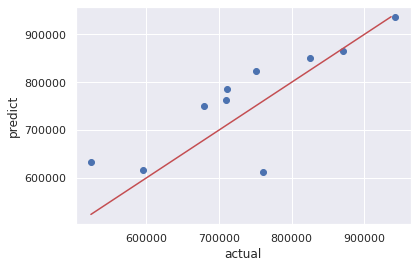

In [22]:
fig, ax = plt.subplots(1, 1)
ax.scatter(y_test_s, y_pred)
ideal_min = min(min(y_test_s), min(y_pred))
ideal_max = min(max(y_test_s), max(y_pred))
ax.plot([ideal_min, ideal_max], [ideal_min, ideal_max], color='r')
ax.set_xlabel('actual')
ax.set_ylabel('predict')
plt.show()

過学習してる

# グリッドサーチ

In [23]:
from sklearn.model_selection import GridSearchCV

In [34]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50,100,200],
    'subsample': [0.5, 1],
    'max_depth': [1, 2, 3]
 }

In [35]:
forest_grid = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=0),
    param_grid = param_grid,   
    cv = 3,              #cross-validation
    n_jobs = 1, #number of core
)

forest_grid.fit(X_train_df, y_train_s) #fit

GridSearchCV(cv=3, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_no_change=None,
                 

In [39]:
# 最適だったパラメータ
pd.Series(forest_grid.best_params_)

learning_rate     0.1
max_depth         3.0
n_estimators     50.0
subsample         0.5
dtype: float64

In [27]:
# 最高性能のモデルを取得し、テストデータを分類
best = forest_grid.best_estimator_
y_pred = best.predict(X_test_df)

In [28]:
# 決定係数 (R2)
r2_score(y_test_s, y_pred)

0.5959502866757338

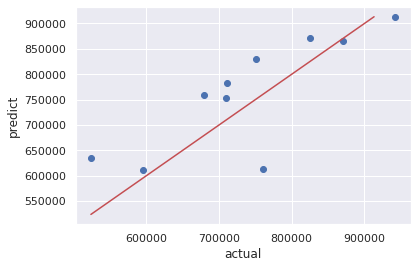

In [29]:
fig, ax = plt.subplots(1, 1)
ax.scatter(y_test_s, y_pred)
ideal_min = min(min(y_test_s), min(y_pred))
ideal_max = min(max(y_test_s), max(y_pred))
ax.plot([ideal_min, ideal_max], [ideal_min, ideal_max], color='r')
ax.set_xlabel('actual')
ax.set_ylabel('predict')
plt.show()

どうにもダメっぽい

# 交差検証

In [30]:
from sklearn.model_selection import cross_val_score

In [32]:
# モデル準備
learn_r = 0.1  #学習率
max_depth = 3  #ツリーの最大深さ
n = 50         #ループ回数
sample_r = 0.5 #ツリー作成時のサンプル使用率

clf = GradientBoostingRegressor(learning_rate=learn_r, n_estimators=n, subsample=sample_r, max_depth=max_depth, random_state=0)
scores = cross_val_score(clf, X_df, y_s, cv=5)
scores

array([-0.39094314,  0.73670513,  0.1854915 ,  0.78374771, -1.06615381])

# まとめ

* とりあえずGBM使ってみたが、精度良く予測するのは難しそう
  * 説明変数（前何回分まで使うか）、ハイパーパラメータをいじっても精度が上がらない
* 原因として思いつくもの
  * 過学習している
    * trainデータが少ないのに、説明変数やestimatorが多すぎる？
  * イベント開催時期によって、説明変数lengthの効き方が変わるのを表現できていない